In [65]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import laplace_asymmetric
from matplotlib.ticker import MultipleLocator
import seaborn as sns

In [67]:
#import dataset
df_complete = pd.read_excel('EA_GDP.xlsx')
df_complete.head()


,TIME,RGDP,CISS,GDPlog,GDPgrowth(annualized),GDPgrowth/400
0,1991Q1,1.851747e+06,0.121591,14.431640,0.026317,0.000066
1,1991Q2,1.856938e+06,0.061375,14.434440,0.024727,0.000062
2,1991Q3,1.857512e+06,0.057187,14.434749,0.015219,0.000038
3,1991Q4,1.876601e+06,0.081339,14.444973,0.019042,0.000048
4,1992Q1,1.902687e+06,0.080447,14.458777,0.027137,0.000068


In [68]:
df = df_complete.drop('TIME', axis=1)
df.head()

,RGDP,CISS,GDPlog,GDPgrowth(annualized),GDPgrowth/400
0,1.851747e+06,0.121591,14.431640,0.026317,0.000066
1,1.856938e+06,0.061375,14.434440,0.024727,0.000062
2,1.857512e+06,0.057187,14.434749,0.015219,0.000038
3,1.876601e+06,0.081339,14.444973,0.019042,0.000048
4,1.902687e+06,0.080447,14.458777,0.027137,0.000068


In [7]:
time = df['TIME'] 
rgdp = df['RGDP'].values.astype(float) 
ciss = df['CISS'].values.astype(float) 
rgdp_an = df['GDPgrowth(annualized)'].values.astype(float) 
rgdp_growth = df['GDPgrowth/400'].values.astype(float) 

rgdp_lag = np.roll(rgdp_an, 1)
rgdp_lag[0] = 0
rgdp_lag_growth = np.roll(rgdp_growth, 1)
rgdp_lag_growth[0] = 0

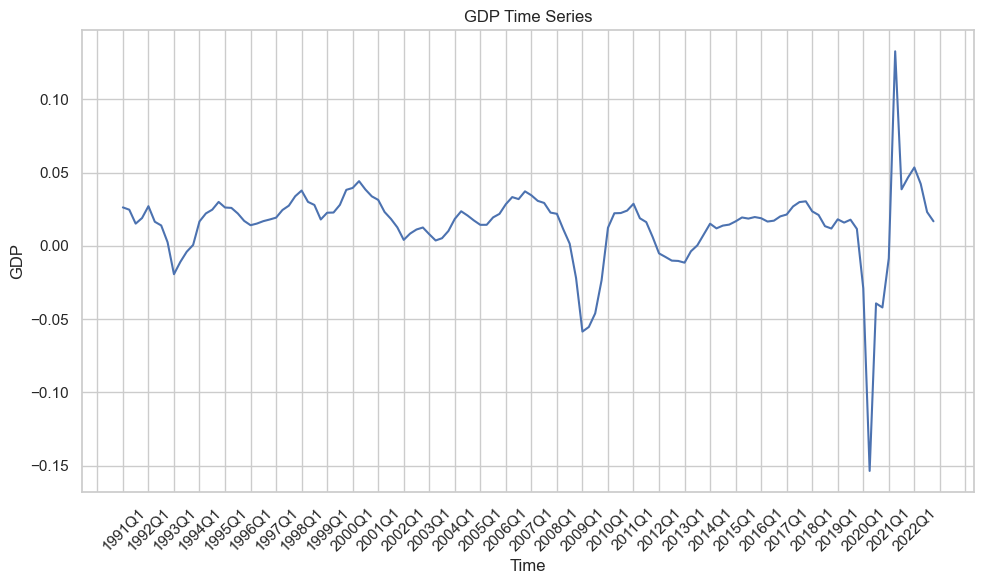

In [64]:
#Time Series Plot
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_complete, x='TIME', y='GDPgrowth(annualized)', ax=ax)
locator = MultipleLocator(base=4)
ax.xaxis.set_major_locator(locator)

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('GDP')
ax.set_title('GDP Time Series')
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()


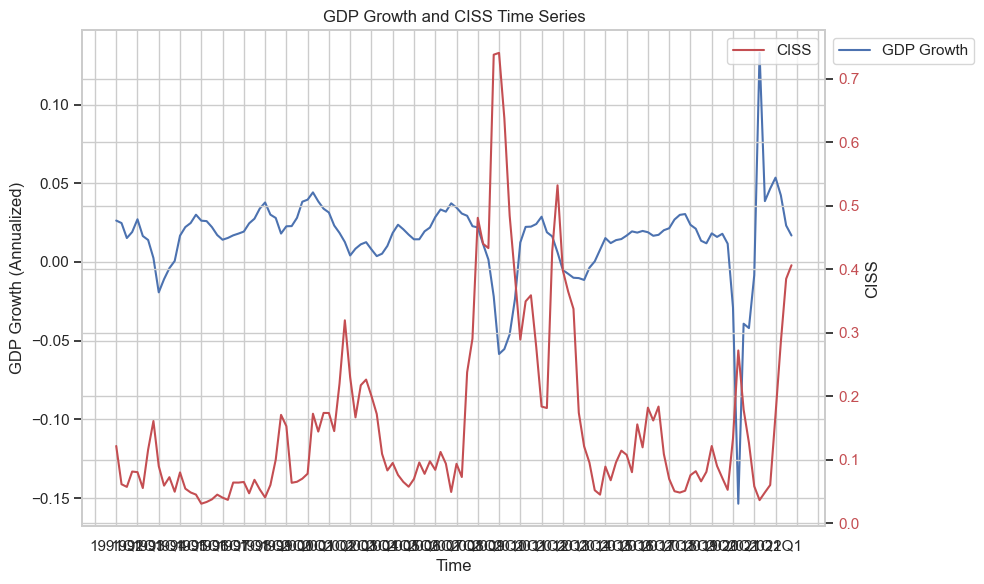

In [58]:

sns.set(style='whitegrid')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the GDP time series
sns.lineplot(data=df, x='TIME', y='GDPgrowth(annualized)', ax=ax, label='GDP Growth')

# Set labels and title for GDP
ax.set_xlabel('Time')
ax.set_ylabel('GDP Growth (Annualized)')
ax.set_title('GDP Growth and CISS Time Series')

# Create a secondary y-axis for CISS
ax2 = ax.twinx()

# Plot the CISS time series
sns.lineplot(data=df, x='TIME', y='CISS', ax=ax2, color='r', label='CISS')

# Set labels and title for CISS
ax2.set_ylabel('CISS')
ax2.tick_params(axis='y', labelcolor='r')

# Remove x-axis labels and ticks from secondary y-axis
ax2.set_xticks([])

# Set locator for x-axis labels
locator = MultipleLocator(base=4)
ax.xaxis.set_major_locator(locator)

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right')

# Display legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the layout
fig.tight_layout()

# Display the plot
plt.show()


In [10]:
''' QL regression with package'''
X = np.column_stack((np.ones_like(rgdp_an), rgdp_lag, ciss))

# Use the standardized variables in the regression analysis
quant_reg_1 = sm.QuantReg(rgdp_an, X).fit(q=0.1)
quant_reg_5 = sm.QuantReg(rgdp_an, X).fit(q=0.5)
quant_reg_9 = sm.QuantReg(rgdp_an, X).fit(q=0.9)

# Print the summary of the quantile regression results
print(quant_reg_1.summary())
print(quant_reg_5.summary())
print(quant_reg_9.summary()) 



                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.4648
Model:                       QuantReg   Bandwidth:                    0.004994
Method:                 Least Squares   Sparsity:                      0.03425
Date:                Fri, 16 Jun 2023   No. Observations:                  128
Time:                        13:52:08   Df Residuals:                      125
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.472      0.638      -0.003       0.004
x1             0.8133      0.052     15.634      0.000       0.710       0.916
x2            -0.0325      0.008     -4.157      0.000      -0.048      -0.017
                         QuantReg Regression Results

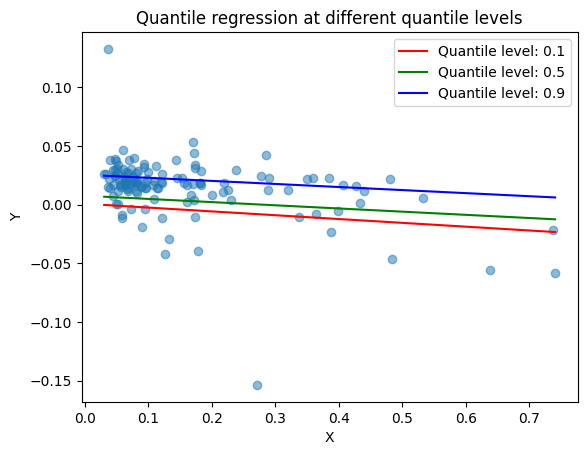

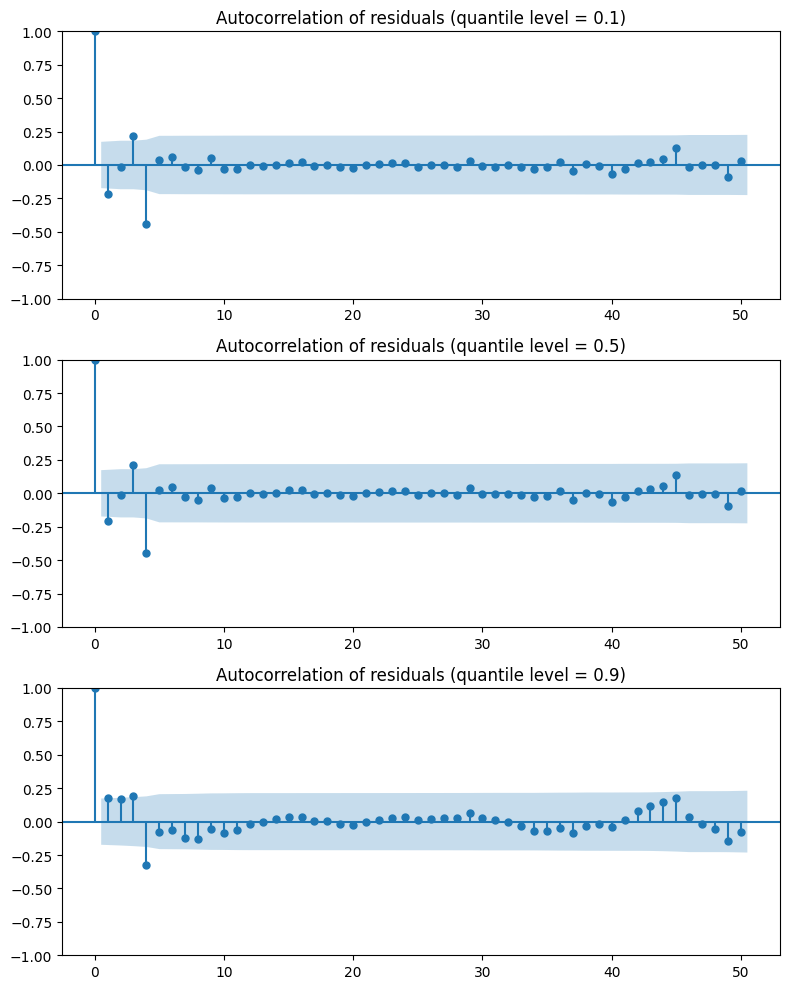

In [23]:
################################ Quantile regression plot ##############################
fig, ax = plt.subplots()
ax.scatter(ciss, rgdp_an, alpha=0.5)

    # Generate x values for the regression lines
x_vals = np.linspace(np.min(ciss), np.max(ciss), 100)
y_vals_lag = np.linspace(np.min(rgdp_lag), np.max(rgdp_lag), 100)
    # Plot the regression lines
ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Quantile regression at different quantile levels')
plt.show()

################################ Autocorrelation of the residuals ##############################
residuals_1 = quant_reg_1.resid # Calculate the residuals
residuals_5 = quant_reg_5.resid # Calculate the residuals
residuals_9 = quant_reg_9.resid # Calculate the residuals

# Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
plot_acf(quant_reg_1.resid, lags=50, ax=ax[0])
ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
plot_acf(quant_reg_5.resid, lags=50, ax=ax[1])
ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
plot_acf(quant_reg_9.resid, lags=50, ax=ax[2])
ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
plt.tight_layout()
plt.show()

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# Perform Ljung-Box test with up to 10 lags
lbtest = acorr_ljungbox(residuals_1, lags=50)

# Print p-values for each lag
print(lbtest)

      lb_stat     lb_pvalue
1    6.367790  1.162103e-02
2    6.409466  4.056973e-02
3   12.858613  4.952557e-03
4   39.111716  6.605936e-08
5   39.275740  2.089869e-07
6   39.774218  5.044979e-07
7   39.795657  1.377365e-06
8   40.018515  3.178378e-06
9   40.357593  6.544687e-06
10  40.512653  1.376055e-05
11  40.640925  2.778095e-05
12  40.641736  5.623738e-05
13  40.646325  1.087236e-04
14  40.647177  2.020846e-04
15  40.696604  3.556747e-04
16  40.750632  6.043200e-04
17  40.765981  1.007977e-03
18  40.767175  1.639054e-03
19  40.803225  2.563315e-03
20  40.872907  3.867740e-03
21  40.874148  5.811481e-03
22  40.881481  8.512780e-03
23  40.924259  1.208065e-02
24  40.975046  1.676227e-02
25  41.016656  2.286491e-02
26  41.017959  3.090524e-02
27  41.019606  4.100752e-02
28  41.053128  5.310641e-02
29  41.236402  6.565983e-02
30  41.248352  8.286158e-02
31  41.277542  1.026794e-01
32  41.279938  1.260418e-01
33  41.321054  1.516123e-01
34  41.466028  1.772042e-01
35  41.515798  2.078

In [21]:
from statsmodels.stats.stattools import durbin_watson
# Perform Durbin-Watson test
dwtest = durbin_watson(residuals_1)

# Print test statistic
print(dwtest)

#positive autocorrelation

2.1810633213791935


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


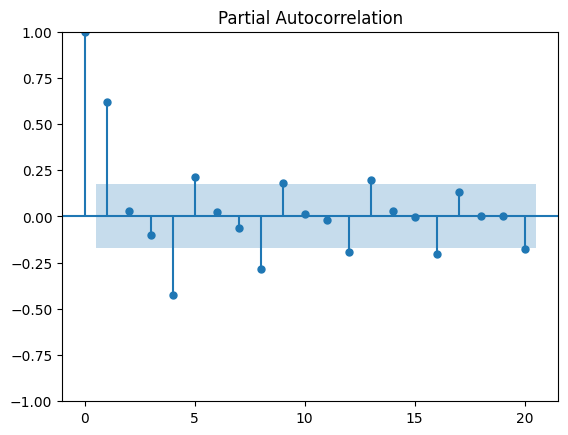

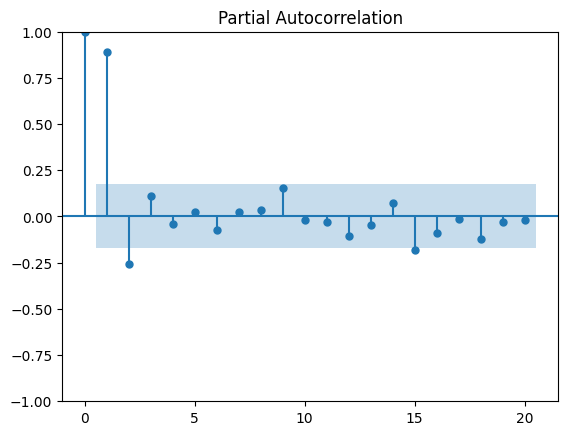

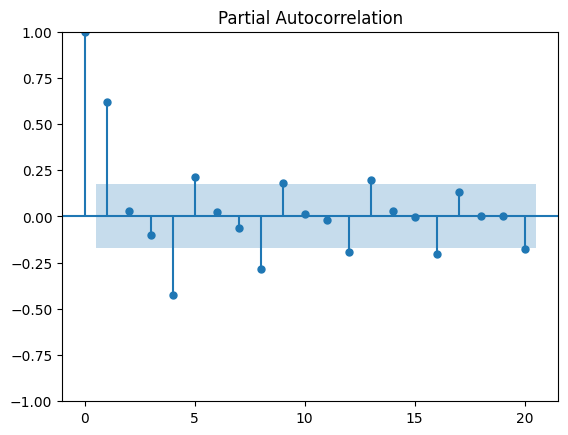

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot PACF of the time series
plot_pacf(ciss, lags=20)
plot_pacf(rgdp_an, lags=20)

In [36]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['GDPgrowth(annualized)'].values
    T = min(M, len(y_dataset))
    y = df['GDPgrowth(annualized)'].values[:T]
    x = df['CISS'].values[:T]  # extract data
    #epsilon_y = df['epsilon_y'].values[:T]

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.normal(T)  # Generate new errors for each iteration
        epsilon = np.random.randn(T) # Generate new errors for each iteration

        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


    actuals = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta
  # Calculate the biases
    biases_ols = actuals - np.array(beta_hat)
    for i, bias in enumerate(biases_ols):
        print(f"OLS_bias_param_{i} = {bias:.4f}")
    
    mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")
    
    biases_gls = actuals - np.array(beta_gls) # Calculate the biases
    for i, bias in enumerate(biases_gls):
        print(f"GLS_bias_param_{i} = {bias:.4f}")
    
    mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")

In [37]:
M=1000
initial_params = 0.0077, 0.7821, -0.0271, 1, 0.0077, 0.7821, -0.0271, 1
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.14838298464622607]
OLS beta_hat:  [-0.03524024167890109]
OLS gamma_hat:  [-0.6125841528685614]
OLS theta_hat:  [0.9999999999999947]
GLS alpha_hat:  [0.14804702644683873]
GLS beta_hat:  [-0.030899676187180737]
GLS gamma_hat:  [-0.611625585723887]
GLS theta_hat:  [1.0000000000002274]
OLS_bias_param_0 = 0.0516
OLS_bias_param_1 = 0.5352
OLS_bias_param_2 = 0.9126
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.5320
GLS_bias_param_0 = 0.0520
GLS_bias_param_1 = 0.5309
GLS_bias_param_2 = 0.9116
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.5305


In [71]:
def Laplace_estimation(df, p, M):

    def log_l_Asym_Lap(params, X, y):
        params = params
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1-p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2*p) / p * (1-p)
        ll -= np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(((y - X @ params - θ * z)**2)/(np.sqrt(τ_2)*np.sqrt(z))**2))
        return -ll

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['GDPgrowth(annualized)'].values
    T = min(M, len(y_dataset))
    y = df['GDPgrowth(annualized)'].values[:T]
    x = df['CISS'].values[:T]  # extract data
    #epsilon_y = df['epsilon_y'].values[:T]
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0

    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
    
        params0 = np.array([0.0077, 0.7821, -0.0271], dtype=float)  # Reshape to 1D array
        
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Nelder-Mead')  # minimize the negative log-likelihood
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1

        actuals = np.array([0.0077, 0.7821, -0.0271])  # True parameters alpha, beta, gamma
        biases = actuals - np.array(beta_laplace)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE
        rmse_matrix[i, :] = rmse  # Store RMSE values in the matrix

    print("Beta Matrix:")
    print(beta_matrix)
    print("\nRMSE Matrix:")
    print(rmse_matrix)
    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))
    print("\nMean of RMSE:")
    print(np.mean(rmse_matrix))

    return beta_matrix

result_matrix = Laplace_estimation(df, 0.5, 100)


Beta Matrix:
[[ 0.0077      0.7821     -0.028455  ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.008085    0.7821     -0.0271    ]
 [ 0.00693     0.821205   -0.028455  ]
 [ 0.0077      0.821205   -0.0271    ]
 [ 0.008085    0.821205   -0.02619667]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.0077      0.821205   -0.0271    ]
 [ 0.0077      0.7821     -0.028455  ]
 [ 0.008085    0.7821     -0.0271    ]
 [ 0.0077      0.7821     -0.028455  ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.0077      0.821205   -0.0271    ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.00795667  0.80817    -0.02800333]
 [ 0.008085    0.7821     -0.0271    ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.0077      0.821205   -0.0271    ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.007315    0.80817    -0.02800333]
 [ 0.00795667  0.80817    -0.02800333]
 [ 0.00780694  0.77666875 -0.02687417]
 [ 0.0077   